In [125]:
%matplotlib inline
import matplotlib.pyplot as plt
import torch
import os
import numpy as np

batch_size = 16
sample_len = 32
box_num = 10

im = np.zeros([1,10,3], dtype=np.uint8)

# Fill with colours of rainbow and greys
im[0,1,:]=[255,0,0]       # red
im[0,0,:]=[255,165,0]     # orange
im[0,3,:]=[220,220,0]     # yellow
im[0,2,:]=[0,255,0]       # green
im[0,7,:]=[0,0,255]       # blue
im[0,8,:]=[75,0,130]      # indigo
im[0,5,:]=[238,130,238]   # violet
im[0,6,:]=[255,0,255]   # purple
im[0,9,:]=[127,127,127]   # grey
im[0,4,:]=[153,255,255]   # light blue

colors = im[0]

In [2]:
from scipy.ndimage.filters import gaussian_filter1d


def numbers(feature):
    x = np.arange(feature.size(0))
    y = feature.cpu().numpy()
    ysmoothed = gaussian_filter1d(y, sigma=2)
    return x, ysmoothed

def align_region(region):
    global batch_size, sample_len, box_num
    region = region.reshape(sample_len, box_num, -1)
    mask = region.sum(-1).eq(0)
    region = region.sum(1) / (~mask).sum(1).unsqueeze(-1).clamp(min=1)
    return region

In [78]:
import argparse
import cv2
import os
import numpy as np
import torch
from PIL import Image
import glob

import torchvision.transforms as transforms
import torch.nn.functional as F
import subprocess

def compute_iou(rec1, rec2):
    """
    computing IoU
    :param rec1: (x0, y0, x1, y1), which reflects
            (bottom, left, top, right)
    :param rec2: (x0, y0, x1, y1)
    :return: scala value of IoU
    """
    # computing area of each rectangles
    S_rec1 = (rec1[2] - rec1[0]) * (rec1[3] - rec1[1])
    S_rec2 = (rec2[2] - rec2[0]) * (rec2[3] - rec2[1])

    # computing the sum_area
    sum_area = S_rec1 + S_rec2

    # find the each edge of intersect rectangle
    left_line = max(rec1[0], rec2[0])
    right_line = min(rec1[2], rec2[2])
    bottom_line = max(rec1[1], rec2[1])
    top_line = min(rec1[3], rec2[3])

    # judge if there is an intersect
    if left_line >= right_line or bottom_line >= top_line:
        return 0.
    else:
        intersect = (right_line - left_line) * (top_line - bottom_line)
        return intersect / (sum_area - intersect)

def show(img, dets, idx):
    """Visual debugging of detections."""
    image_tmp = np.array(img)
    im = image_tmp[:,:,::-1].copy()
    dets = dets.cpu()
    global colors
    global thresh
    global draw_boxes
    if draw_boxes is None:
        draw_boxes = range(dets.shape[0])
    for i in draw_boxes:
        score = dets[i, 0]
        if score<=thresh:
            continue
        bbox = tuple(int(np.round(x)) for x in dets[i, 1:])
        color = (int(colors[i][2]), int(colors[i][1]), int(colors[i][0]))
        cv2.rectangle(im, bbox[0:2], bbox[2:4], color, 2)
#         top_right = (bbox[0]+5, bbox[1]+30)
#         im = cv2.putText(im, str(i), top_right, cv2.FONT_HERSHEY_SIMPLEX,  
#                1, (255, 255, 255), 1, cv2.LINE_AA) 

    return im

def concat_pic(cls_det, imgs):
    image = []
    im_list_2d = []
    rows = 4
    global sample_len
    for idx in range(sample_len):
        image.append(show(imgs[idx], cls_det[idx], idx))
    for row in range(rows):
        im_list_2d.append(image[len(image) * row // rows: len(image) * (row+1) //rows])
    # im_list_2d = [image[:len(image)//2], image[len(image)//2:]]
    return cv2.vconcat([cv2.hconcat(im_list_h) for im_list_h in im_list_2d])

class GroupResize(object):
    def __init__(self, size, interpolation=Image.BILINEAR):
        self.worker = transforms.Resize(size, interpolation)
        
    def __call__(self, img_group):
        return [self.worker(img) for img in img_group]

class GroupCenterCrop(object):
    def __init__(self, size):
        self.worker = transforms.CenterCrop(size)

    def __call__(self, img_group):
        return [self.worker(img) for img in img_group]

def process_align():
    cls_det_ = []
    cls_det_.append(cls_det[0][box].unsqueeze(0))

    sim = F.normalize(feat, p=2, dim=-1)
    sim = torch.matmul(sim, sim.transpose(0, 1))  # N, N
    sim = sim[:10] # 10, N

    box_n = cls_det[0] # 10, 5
    iou = torch.zeros_like(sim) # 10, N

    for i in range(1, 32):
        for j in range(10):
            for k in range(10):
                iou[j, i*10+k] = compute_iou(box_n[j], cls_det[i, k])

    sim += iou

    for i in range(1, 32):
        feat_single = feat[i*10 : (i+1)*10]  # box, d
        sim_single = sim[:, i*10 : (i+1)*10]  # box, box
        cls_single = cls_det[i]

        sim_ = sim_single[box]  # box
        _, idx = sim_.max(0)
        cls_det_.append(cls_single[idx].unsqueeze(0))
    cls_det_ = torch.stack(cls_det_)

    return cls_det_
    

def cls(video_id):
    transform = transforms.Compose([
                GroupResize(256),
                GroupCenterCrop(256),
                ])

    dataset = 'MSRVTT'

    frames_path = './feats/{}/frames/'.format(dataset)
    bbox_path = './feats/{}/bbox_conf_0.1_nms_0.5'.format(dataset)

    video = video_id
    cls_dets = torch.load(bbox_path+'/'+video+'.pth')

    imgs = glob.glob(frames_path + video +'/*.jpg')
    imgs.sort()
    
    sample_frame = np.linspace(0, len(imgs)-1, 32, dtype=np.int)

    feat_len = len(sample_frame)
    imgs = [imgs[idx] for idx in sample_frame]


    imgs = [Image.open(img).convert('RGB') for img in imgs]
    imgs = transform(imgs)

    cls_det = cls_dets[sample_frame]  # t, 50, 5
    cls_det_new = torch.zeros_like(cls_det)
    for i in range(feat_len):
        cls_single = cls_det[i]  # 50, 5
        cls_single = cls_single[cls_single[:, 0]>0.1]
        boxes = []
        for j in range(len(cls_single)):
            if (cls_single[j,3]-cls_single[j,1]) * (cls_single[j,4]-cls_single[j,2])>300:
                boxes.append(cls_single[j])
        if len(boxes)==0:
            continue
        boxes = torch.stack(boxes)  # n, 5
        cls_det_new[i, :len(boxes)] = boxes
    cls_det = cls_det_new[:, :10]
    return imgs, cls_det
    

def draw_pic(imgs, cls_det, frame_index=-1):    
    if frame_index != -1:
        pic = show(imgs[frame_index], cls_det[frame_index], frame_index)
    else:
        pic = concat_pic(cls_det, imgs)
    return pic

def draw_weight(weights, video_id, i, lw=1, alpha=0.8):
    axes = plt.gca()
    axes.set_xlim([0, 512])
    axes.set_ylim([0, 1])
    
    frame = weights['frame'][video_id]
    frame = frame[i]
    x_f, y_f = numbers(frame)
    if not frame.eq(0.5).all():
        plt.plot(x_f, y_f, 'k', lw=lw)

    region = weights['region'][video_id]  # 320, d
    
    global draw_boxes
    if draw_boxes is None:
        draw_boxes = range(box_num)
    for box in draw_boxes:
        region_ = region[box_num*i+box]
        if region_.eq(0.5).all() or cls_det[i, box, 0]<=thresh:
            continue

        x_r, y_r = numbers(region_)
#         plt.plot(x_r, y_r, lw=0.7, color=colors[box]/255)
        axes.plot(x_r, y_r, lw=lw, color=colors[box]/255, alpha=alpha)


In [4]:
wcm_weights = torch.load('generated_weight/wcm_weight.pth')
frame_weights = torch.load('generated_weight/frame_weight.pth')
box_weights = torch.load('generated_weight/box_weight.pth')

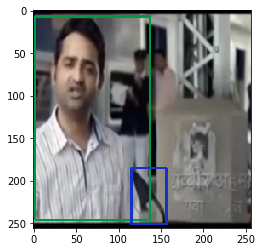

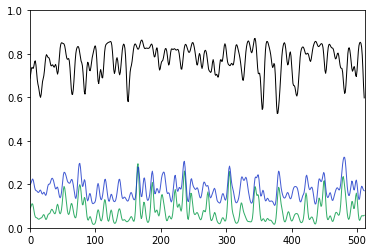

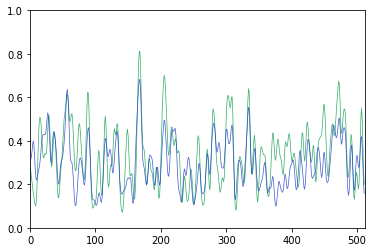

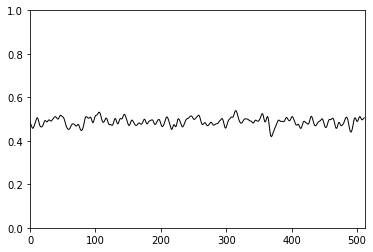

In [142]:
im[0,0,:]=[0,153,68]    # orange
im[0,4,:]=[20,50,200]    # light blue
# im[0,6,:]=[228,0,127]   # red
im[0,7,:]=[243,152,0]   # red
im[0,6,:]=[20,50,200]   # light blue

colors = im[0]

os.makedirs('generated_weight/pic', exist_ok=True)
os.makedirs('generated_weight/wcm', exist_ok=True)
os.makedirs('generated_weight/frame', exist_ok=True)
os.makedirs('generated_weight/box', exist_ok=True)

# video_id = 'video7184'
video_id = 'video7424'
imgs, cls_det = cls(video_id)

# i, draw_boxes, thresh = 9, [0, 6, 7], 0
i, draw_boxes, thresh = 27, [0, 4], 0
save = True
lw = 0.7

pic = draw_pic(imgs, cls_det, i)
plt.imshow(pic[:,:,::-1])
# plt.imshow(imgs[i])
if save:
    cv2.imwrite("generated_weight/pic/%s_%d.png"%(video_id, i), pic)

fig = plt.figure()
draw_weight(wcm_weights, video_id, i, 1)
if save:
    plt.savefig("generated_weight/wcm/%s_%d.svg"%(video_id, i), format="svg")

fig = plt.figure()
draw_weight(box_weights, video_id, i, lw)
if save:
    plt.savefig("generated_weight/box/%s_%d.svg"%(video_id, i), format="svg")

fig = plt.figure()
draw_weight(frame_weights, video_id, i, 1)
if save:
    plt.savefig("generated_weight/frame/%s_%d.svg"%(video_id, i), format="svg")

In [13]:
# video_id = 'video7424'
# imgs, cls_det = cls(video_id)

# fig_size = 3
# thresh = 0.
# rows = 32
# fig = plt.figure(figsize=(fig_size, fig_size*rows))

# for i in range(rows):
#     plt.subplot(rows, 3, i*3+1)
#     pic = draw_pic(imgs, cls_det, i)
#     plt.imshow(pic[:,:,::-1])
    
#     plt.subplot(rows, 3, i*3+2)
#     draw_weight(wcm_weights, video_id, i)
    
#     plt.subplot(rows, 3, i*3+3)
#     plt.text(0, 0, str(i), color="red", fontsize=12)




In [7]:
weights = wcm_weights

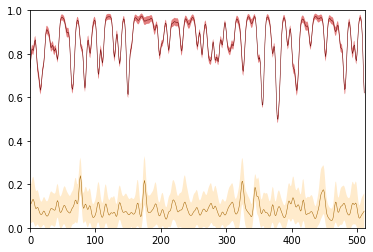

In [8]:
video_id = 'video7184'

fig, ax = plt.subplots(1)
frame = weights['frame'][video_id]
frame_mean = frame.mean(0)
frame_std = np.std(frame.numpy(), axis=0)

y_mean = gaussian_filter1d(frame_mean.numpy(), sigma=2)
y_std = gaussian_filter1d(frame_std, sigma=2)


x = np.arange(frame_mean.shape[0])
ax.fill_between(x, y_mean-y_std, y_mean+y_std, facecolor=colors[6]/255, alpha=0.5)

x_f, y_f = numbers(frame_mean)
plt.plot(x_f, y_f, lw=0.5, color=colors[6]/500)

frame = weights['region'][video_id]
frame = frame[frame.sum(-1)!=256.]
frame_mean = frame.mean(0)
frame_std = np.std(frame.numpy(), axis=0)

y_mean = gaussian_filter1d(frame_mean.numpy(), sigma=2)
y_std = gaussian_filter1d(frame_std, sigma=2)


x = np.arange(frame_mean.shape[0])
ax.fill_between(x, y_mean-y_std, y_mean+y_std, facecolor=colors[0]/255, alpha=0.2)


x_f, y_f = numbers(frame_mean)
plt.plot(x_f, y_f, lw=0.5, color=colors[0]/400)

axes = plt.gca()
axes.set_xlim([0, 512])
axes.set_ylim([0, 1])
    
plt.savefig("generated_weight/pic/mean_single.svg", format="svg")


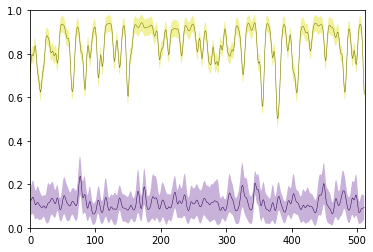

In [9]:
tmp = []
for keys in weights['frame']:
    frame = weights['frame'][keys]
    tmp.append(frame.mean(0))
tmp = torch.stack(tmp)



fig, ax = plt.subplots(1)

frame_mean = tmp.mean(0)
frame_std = np.std(tmp.numpy(), axis=0)

y_mean = gaussian_filter1d(frame_mean.numpy(), sigma=2)
y_std = gaussian_filter1d(frame_std, sigma=2)


x = np.arange(frame_mean.shape[0])
ax.fill_between(x, y_mean-y_std, y_mean+y_std, facecolor=colors[3]/255, alpha=0.4)
# ax.fill_between(t, mu1+sigma1, mu1-sigma1, facecolor='blue', alpha=0.5)



x_f, y_f = numbers(frame_mean)
plt.plot(x_f, y_f, lw=0.5, color=colors[3]/500)

tmp = []
for keys in weights['region']:
    frame = weights['region'][keys]
    frame = frame[frame.sum(-1)!=256.]
    if len(frame)==0:
        continue
    tmp.append(frame.mean(0))
tmp = torch.stack(tmp)

frame_mean = tmp.mean(0)
frame_std = np.std(tmp.numpy(), axis=0)

y_mean = gaussian_filter1d(frame_mean.numpy(), sigma=2)
y_std = gaussian_filter1d(frame_std, sigma=2)

x = np.arange(frame_mean.shape[0])
ax.fill_between(x, y_mean-y_std, y_mean+y_std, facecolor=colors[1]/255, alpha=0.3)

x_f, y_f = numbers(frame_mean)
plt.plot(x_f, y_f, lw=0.5, color=colors[1]/400)

axes = plt.gca()
axes.set_xlim([0, 512])
axes.set_ylim([0, 1])

plt.savefig("generated_weight/pic/mean.svg", format="svg")
